# Plot qPCR of stability of exported RNA in supernatant

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_stability_supernatant"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_stability_supernatant_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)

print(cq_raw.shape)
cq_raw.head()

(38, 13)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
0,A01,SYBR,mCherry,Unkn-01,95B-1,NaN,19.668777,19.841279,0.177076,59300.928305,4.773061,52941.774474,6389.888117
1,A02,SYBR,mCherry,Unkn-02,95B-2,NaN,18.994219,19.132174,0.120362,94192.961120,4.974018,85885.791159,7240.685850
2,A03,SYBR,mCherry,Unkn-03,95B-3,NaN,19.687712,19.077021,0.535270,58535.684629,4.767421,92780.809524,30301.015601
3,A04,SYBR,mCherry,Unkn-04,95B-4,NaN,20.463358,19.628986,0.754684,34383.390661,4.536349,66154.495461,30083.449489
4,A05,SYBR,mCherry,Unkn-05,95B-5,NaN,20.248376,19.924798,0.282833,39846.820138,4.600394,50354.414834,9216.376298


# Preprocess data

## Calculate total starting molecules

In [5]:
# Calculate normalization for input volume
DILUTION_FACTORS = (350/140) * (42/20) * (61/10) * (20/1)

In [6]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [7]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [8]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
95B-1,52941.774474,6389.888117,5.691545e+09,6.869497e+08
95B-11,26362.018096,4289.716597,2.834069e+09,4.611692e+08
95B-12,6148.800443,1767.903533,6.610314e+08,1.900598e+08
95B-13,14250.596970,5368.561282,1.532021e+09,5.771512e+08
95B-14,6230.162577,1943.132621,6.697783e+08,2.088979e+08
95B-15,9374.066932,1862.061109,1.007766e+09,2.001823e+08
95B-2,85885.791159,7240.685850,9.233217e+09,7.784154e+08
95B-3,92780.809524,30301.015601,9.974471e+09,3.257533e+09
95B-4,66154.495461,30083.449489,7.111989e+09,3.234144e+09


## Calculate relative abundance (compared with appropriate references)

In [9]:
# Initialize columns

summary["RNA molecules relative to reference"] = np.nan
summary["RNA molecules relative to reference STD"] = np.nan

cq_raw["RNA molecules relative to reference"] = np.nan
cq_raw["RNA molecules relative to reference STD"] = np.nan

In [10]:
# Calculate RNA molecules relative to reference

# Gag-MCP, 37 C

ref = summary.loc["95B-1", "RNA molecules"]  # set reference value
samples = ["95B-1", "95B-2", "95B-3", "95B-4", "95B-5"]  # samples that use this reference value

summary.loc[samples, "RNA molecules relative to reference"] = summary.loc[samples, "RNA molecules"] / ref
summary.loc[samples, "RNA molecules relative to reference STD"] = summary.loc[samples, "RNA molecules STD"] / ref

# EPN24-MCP, 37 C

ref = summary.loc["95B-11", "RNA molecules"]  # set reference value
samples = ["95B-11", "95B-12", "95B-13", "95B-14", "95B-15"]  # samples that use this reference value

summary.loc[samples, "RNA molecules relative to reference"] = summary.loc[samples, "RNA molecules"] / ref
summary.loc[samples, "RNA molecules relative to reference STD"] = summary.loc[samples, "RNA molecules STD"] / ref


In [11]:
# Repeat for raw Cq values

cq_raw = cq_raw.set_index("Sample")

# Gag-MCP, 37 C

ref = summary.loc["95B-1", "RNA molecules"]  # set reference value
samples = ["95B-1", "95B-2", "95B-3", "95B-4", "95B-5"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules relative to reference"] = cq_raw.loc[samples, "RNA molecules"] / ref
cq_raw.loc[samples, "RNA molecules relative to reference STD"] = cq_raw.loc[samples, "RNA molecules STD"] / ref

# EPN24-MCP, 37 C

ref = summary.loc["95B-11", "RNA molecules"]  # set reference value
samples = ["95B-11", "95B-12", "95B-13", "95B-14", "95B-15"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules relative to reference"] = cq_raw.loc[samples, "RNA molecules"] / ref
cq_raw.loc[samples, "RNA molecules relative to reference STD"] = cq_raw.loc[samples, "RNA molecules STD"] / ref

cq_raw = cq_raw.reset_index()

In [12]:
# Convert to percentage

summary["RNA molecules relative to reference %"] = summary["RNA molecules relative to reference"] * 100
summary["RNA molecules relative to reference STD %"] = summary["RNA molecules relative to reference STD"] * 100

cq_raw["RNA molecules relative to reference %"] = cq_raw["RNA molecules relative to reference"] * 100
cq_raw["RNA molecules relative to reference STD %"] = cq_raw["RNA molecules relative to reference STD"] * 100

In [13]:
summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules relative to reference,RNA molecules relative to reference STD,RNA molecules relative to reference %,RNA molecules relative to reference STD %
Sample,,,,,,,,
95B-1,52941.774474,6389.888117,5.691545e+09,6.869497e+08,1.000000,0.120697,100.000000,12.069652
95B-11,26362.018096,4289.716597,2.834069e+09,4.611692e+08,1.000000,0.162723,100.000000,16.272338
95B-12,6148.800443,1767.903533,6.610314e+08,1.900598e+08,0.233245,0.067063,23.324468,6.706253
95B-13,14250.596970,5368.561282,1.532021e+09,5.771512e+08,0.540573,0.203648,54.057307,20.364758
95B-14,6230.162577,1943.132621,6.697783e+08,2.088979e+08,0.236331,0.073710,23.633102,7.370955
95B-15,9374.066932,1862.061109,1.007766e+09,2.001823e+08,0.355590,0.070634,35.558988,7.063424
95B-2,85885.791159,7240.685850,9.233217e+09,7.784154e+08,1.622269,0.136767,162.226884,13.676697
95B-3,92780.809524,30301.015601,9.974471e+09,3.257533e+09,1.752507,0.572346,175.250661,57.234605
95B-4,66154.495461,30083.449489,7.111989e+09,3.234144e+09,1.249571,0.568237,124.957080,56.823652


## Censor by lower limit of quantification

In [14]:
# Lower limit of quantification is set based on maximum signal from no template control (NTC) wells.

LOD = cq_raw.set_index("Sample").loc["NTC", "RNA molecules"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 14345897.366753474


In [15]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

# Define function for fitting exponential decay

In [16]:
from scipy.optimize import curve_fit

def fit_exponential(x, y, a_guess=100, k_guess=0):
    
    # Fit the function a * np.exp(k * t) + b to x and y
    
    try:
        popt, pcov = curve_fit(lambda t, a, k: a * np.exp(k * x), x, y, p0=(a_guess, k_guess))
    except RuntimeError:
        popt = None
        pcov = None

    return popt, pcov

# Visualize RNA stability in supernatant

## Gag-MCP

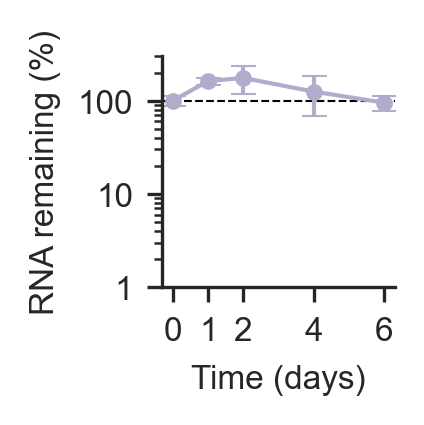

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(1,1))

ax.set_yscale("log")

index_ordered = ["95B-1", "95B-2", "95B-3", "95B-4", "95B-5"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0, 1, 2, 4, 6]

x = summary_subset["Time"]
y = summary_subset["RNA molecules relative to reference %"]
yerr = summary_subset["RNA molecules relative to reference STD %"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color="#b1accc",
            marker=".",
            capsize=3,
            capthick=0.5,
            lw=1,
            label="37 C")

ax.set_ylim(1, 300)

ax.set_xticks([0, 1, 2, 4, 6])

ax.set_xlabel("Time (days)")
ax.set_ylabel("RNA remaining (%)")
ax.set_yticklabels(["", "1", "10", "100"])

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.axhline(100, lw=0.5, c="k", ls="--", zorder=-1)

sns.despine()

save_figure(fig, "stability_supernatant_GagMCP_37C")

In [18]:
popt, pcov = fit_exponential(x, y)

tao = np.log(2)/-popt[1]  # calculate half-life
tao_std = np.log(2)/np.sqrt(pcov[1,1])  # calculate standard deviation of fitted half-life

print("Half-life (days):", tao)
print("Half-life STD (days):", tao_std)
print()

Half-life (days): 18.990605625720942
Half-life STD (days): 10.78786466957782



## EPN24-MCP

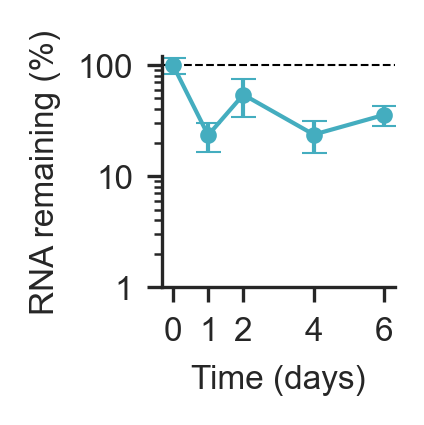

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1,1))

ax.set_yscale("log")

index_ordered = ["95B-11", "95B-12", "95B-13", "95B-14", "95B-15"]
summary_subset = summary.loc[index_ordered]
summary_subset["Time"] = [0, 1, 2, 4, 6]

x = summary_subset["Time"]
y = summary_subset["RNA molecules relative to reference %"]
yerr = summary_subset["RNA molecules relative to reference STD %"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color="#44adbf",
            marker=".",
            capsize=3,
            capthick=0.5,
            lw=1,
            label="37 C")

ax.set_ylim(1, 120)

ax.set_xticks([0, 1, 2, 4, 6])

ax.set_xlabel("Time (days)")
ax.set_ylabel("RNA remaining (%)")
ax.set_yticklabels(["", "1", "10", "100"])

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.axhline(100, lw=0.5, c="k", ls="--", zorder=-1)

sns.despine()

save_figure(fig, "stability_supernatant_EPN24MCP_37C")

In [20]:
popt, pcov = fit_exponential(x, y)

tao = np.log(2)/-popt[1]  # calculate half-life
tao_std = np.log(2)/np.sqrt(pcov[1,1])  # calculate standard deviation of fitted half-life

print("Half-life (days):", tao)
print("Half-life STD (days):", tao_std)
print()

Half-life (days): 2.5769361017926347
Half-life STD (days): 3.6509788689560048

